In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
remove_attention_failers = 0

In [ ]:
def label_category(tail, shape):
    if tail == "T" and shape == "S":
        return "high"
    elif tail == "N" and shape == "C":
        return "low"
    else:
        return "medium"

def extract_basic_info(csv_path):
    df = pd.read_csv(csv_path)
    
    # Free text responses (their explanations)
    free_texts = df['explanation_box.text'].dropna().tolist()
    
    # Feedback (free text response about experiment)
    feedback = df['feedback_text.text'].dropna().tolist()

    #Actual food needed (food needed on each training trial)
    food_amount = df['food_amount'].dropna().tolist()
    
    # Trial stop time (time it took to finish the training loop)
    isi_values = df['ISI.stopped'].dropna().tolist()

    #Get the ISI value for the last training trial, store it
    trial_stop_time = isi_values[-1] if isi_values else np.nan

    #First row with a non-empty value in 'images_list', which shows the order of testing images presented
    images_row = df[df['images_list'].notna()].iloc[0] if not df[df['images_list'].notna()].empty else None

    #Turn the images from PNGs to names
    images = [img.split('/')[-1].replace('.png','') for img in images_row['images_list'].split(',')]

    #First row with a non-empty value in 'sliderRatings', which shows the ratings for testing images
    ratings_row = df[df['sliderRatings'].notna()].iloc[0] if not df[df['sliderRatings'].notna()].empty else None

    #Turn them into floats split by commas
    ratings = [float(r) for r in ratings_row['sliderRatings'].strip('[]').split(',')]

    #Across the training trials, add information about features (what food category, what feature)
    train_categories =  df['category'].dropna().tolist()
    train_tail = df['tail'].dropna().tolist()
    train_shape = df['shape'].dropna().tolist()
    train_color = df['color'].dropna().tolist()


    #Categories for the testing images, in the order shown
    test_categories =  [label_category(stim.split('_')[0], stim.split('_')[2]) for stim in images]

    #Write condition (this is the unique identifier for a certain order of trials)
    condition = images_row['condition'] if images_row is not None and 'condition' in images_row else np.nan

    #Add in the order of images during training
    training_image_order = [img.split('/')[-1].replace('.png','') 
                        for img in df['image_file'].dropna().tolist()]
    
    #Updated code to get slider responses (subjective reports of feature relevance)
    slider_responses = {}
    features = ['shape', 'color', 'tail']
    for feat in features:
        # subset only rows of this feature
        sub = df[df['feature'] == feat]

        # 1. discrete
        disc = sub['discrete_slider.response']
        disc_val = disc[disc.notna() & (disc != "")].iloc[0] if (disc.notna() & (disc != "")).any() else np.nan
        print(disc_val)
        slider_responses[f'{feat}_discrete_slider.response'] = disc_val

        # 2. direction (only for "Yes" responses)
        dirc = sub['direction_response_label']
        dirc_val = dirc[dirc.notna() & (dirc != "")].iloc[0] if (dirc.notna() & (dirc != "")).any() and disc_val != 'No' else np.nan #only store direction if discrete was "Yes"
        slider_responses[f'{feat}_direction_slider.response'] = dirc_val

        # 3. continuous
        cont = sub['continuous_slider.response']
        cont_val = cont[cont.notna() & (cont != "")].iloc[0] if (cont.notna() & (cont != "")).any() and disc_val != 'No' else np.nan #only store continuous if discrete was "Yes"
        print(cont_val)
        slider_responses[f'{feat}_continuous_slider.response'] = cont_val

    #Adding attention check result
    att_rows = df[df['button_3_correct.numClicks'].notna()]
    if not att_rows.empty:
        att_val = att_rows.iloc[0]['button_3_correct.numClicks']
    else:
        att_val = np.nan
    attention_check = 1 if att_val == 1 else 0

    result = {
        'participant': os.path.basename(csv_path)[:3],
        'free_texts': free_texts,
        'feedback': feedback,
        'food_amount': food_amount,
        'trial_stop_time': trial_stop_time,
        'testing_image_order': images,
        'testing_responses': ratings,
        'training_categories': train_categories,
        'training_tail': train_tail,
        'training_shape': train_shape,
        'training_color': train_color,
        'testing_categories': test_categories,
        'conditionOrder': condition,
        'training_image_order': training_image_order,
        'attention_check': attention_check
    }
    result.update(slider_responses)
    return result

topdir = '/Users/sm6511/Desktop/Prediction-Accomodation-Exp'
study = 'NewTest'
date = '2025-12-05'
datadir = os.path.join(topdir, f'data/{study}/Accommodate')
cleaneddir = os.path.join(topdir, f'data/{study}/Cleaned')
all_participants = []

for fname in os.listdir(datadir):
    if fname.endswith('.csv') and fname:
        participant_id = fname[:3]
        if date not in fname:  # skip files
            continue
        csv_path = os.path.join(datadir, fname)
        print(csv_path)
        info = extract_basic_info(csv_path)
        all_participants.append(info)

df_all = pd.DataFrame(all_participants)
if remove_attention_failers:
    df_all = df_all[df_all['attention_check'] == 1]
    df_all.to_csv(os.path.join(cleaneddir, 'PilotAccomodate.csv'), index=False)
else:
    df_all.to_csv(os.path.join(cleaneddir, 'PilotAccomodate.csv'), index=False)
print(df_all)

/Users/sm6511/Desktop/Prediction-Accomodation-Exp/data/NewTest/Accommodate/001_explain2_2025-12-05_16h55.57.129.csv
Yes
5.0
Yes
4.0
No
nan
  participant free_texts feedback  \
0         001     [test]     [aa]   

                                         food_amount  trial_stop_time  \
0  [2.0, 3.0, 7.0, 2.0, 4.0, 4.0, 5.0, 4.0, 6.0, ...          107.132   

                                 testing_image_order  \
0  [T_Y_C, T_Y_S, N_B_C, N_Y_C, T_B_S, T_B_C, N_B...   

                           testing_responses  \
0  [7.0, 4.0, 4.0, 6.0, 6.0, 6.0, 5.0, 10.0]   

                                 training_categories  \
0  [low, low, high, medium, high, medium, medium,...   

                                       training_tail  \
0  [N, N, T, N, T, T, N, T, T, T, N, N, T, T, N, ...   

                                      training_shape  ... attention_check  \
0  [C, C, S, S, S, C, S, C, S, S, C, S, C, C, S, ...  ...               1   

  shape_discrete_slider.response  shape_directio

In [87]:
explainer_time = df_all.groupby(['participant'])['trial_stop_time'].sum()

print(explainer_time)
#explainer_time = explainer_time.to_frame(name='trial_stop_time')

#explainer_time['Explainer_Quality'] = ['No', 'Tracked', 'Tracked', 'Tracked', 'No', 'No']

#print(explainer_time)


participant
001    107.132
Name: trial_stop_time, dtype: float64


In [89]:
participant_id = '001'

row = df_all[df_all['participant'] == participant_id]

free_texts = row['free_texts'].iloc[0] 
feedback = row['feedback'].iloc[0]
print(f"Free text responses for participant {participant_id}:")
for i, text in enumerate(free_texts, 1):
    print(f"Response {i}: {text}")

print(f"\nFeedback for participant {participant_id}: {feedback}")


Free text responses for participant 001:
Response 1: test

Feedback for participant 001: ['aa']


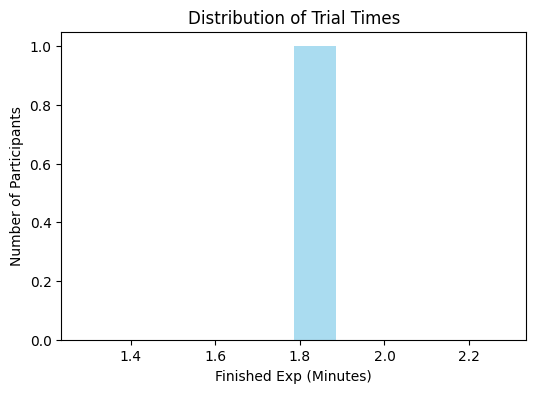

In [90]:
plt.figure(figsize=(6,4))
plt.hist(df_all['trial_stop_time'].dropna()/60, bins=10, color='skyblue', alpha=0.7)
plt.xlabel('Finished Exp (Minutes)')
plt.ylabel('Number of Participants')
plt.title('Distribution of Trial Times')
plt.savefig('PrePilotPlots/trial_times_histogram.png')
plt.show()

In [91]:
print(df_all['participant'].unique())

['001']


  participant free_texts feedback  \
0         001     [test]     [aa]   

                                         food_amount  trial_stop_time  \
0  [2.0, 3.0, 7.0, 2.0, 4.0, 4.0, 5.0, 4.0, 6.0, ...          107.132   

                                 testing_image_order  \
0  [T_Y_C, T_Y_S, N_B_C, N_Y_C, T_B_S, T_B_C, N_B...   

                           testing_responses  \
0  [7.0, 4.0, 4.0, 6.0, 6.0, 6.0, 5.0, 10.0]   

                                 training_categories  \
0  [low, low, high, medium, high, medium, medium,...   

                                       training_tail  \
0  [N, N, T, N, T, T, N, T, T, T, N, N, T, T, N, ...   

                                      training_shape  ... attention_check  \
0  [C, C, S, S, S, C, S, C, S, S, C, S, C, C, S, ...  ...               1   

  shape_discrete_slider.response  shape_direction_slider.response  \
0                            Yes                           Square   

  shape_continuous_slider.response  color_discre

'\n\n# --- Right subplot (Tracking Participants) ---\nax = axes[1]\nbars = ax.bar(avg_other.index, avg_other.values, color=[\'red\',\'green\',\'blue\'], alpha=0.7)\nfor bar in bars:\n    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,\n            f"{bar.get_height():.2f}", ha=\'center\')\nax.set_title(\'Trackers\')\nax.set_ylim(0, 10)\n\nplt.suptitle("Average Food Ratings by Stimulus Category", y=1.05, fontsize=14)\nplt.tight_layout()\nplt.show()\n'

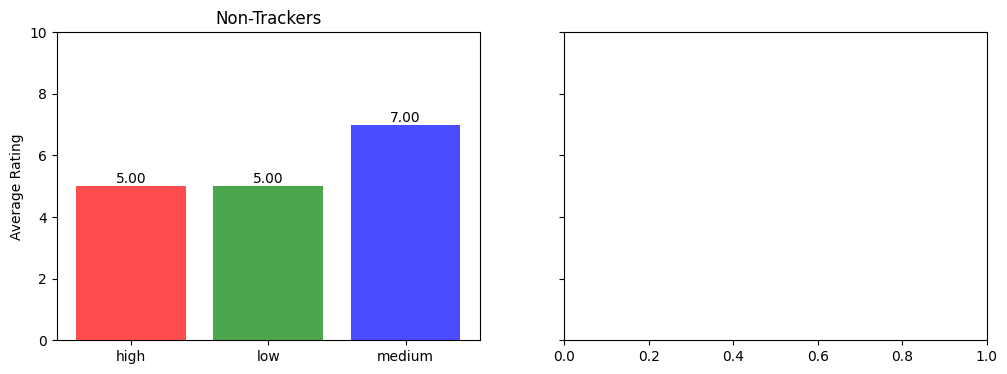

In [ ]:
def AverageFoodCalclator(participants_to_use):
    df_subset = df_all[df_all['participant'].isin(participants_to_use)]
    print(df_subset)
    all_trials = []
    for i in df_subset['participant']:
        trial_order = df_subset[df_subset['participant'] == i]['testing_image_order'].iloc[0]
        ratings = df_subset[df_subset['participant'] == i]['testing_responses'].iloc[0]
        categories = df_subset[df_subset['participant'] == i]['testing_categories'].iloc[0]
    
        df_participant = pd.DataFrame({
            'participant': i,
            'trial_order': trial_order,
            'ratings': ratings,
            'categories': categories
        })
        all_trials.append(df_participant)
    df_average = pd.concat(all_trials, ignore_index=True)
    avg_ratings = df_average.groupby('categories')['ratings'].mean()
    return avg_ratings

participants_selected = ['005', '010', '011', '015', '019', '020', '023', '024', '029']
participants_all = df_all['participant'].tolist()

# Subset groups
participants_other = [p for p in participants_all if p not in participants_selected]

# Compute averages
avg_sel   = AverageFoodCalclator(participants_selected)
avg_other = AverageFoodCalclator(participants_other)


fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

# --- Left subplot (non tracking Participants) ---
ax = axes[0]
bars = ax.bar(avg_sel.index, avg_sel.values, color=['red','green','blue'], alpha=0.7)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f"{bar.get_height():.2f}", ha='center')
ax.set_ylabel('Average Rating')
ax.set_title('Non-Trackers')
ax.set_ylim(0, 10)

# --- Right subplot (Tracking Participants) ---
ax = axes[1]
bars = ax.bar(avg_other.index, avg_other.values, color=['red','green','blue'], alpha=0.7)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f"{bar.get_height():.2f}", ha='center')
ax.set_title('Trackers')
ax.set_ylim(0, 10)

plt.suptitle("Average Food Ratings by Stimulus Category", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()



In [95]:
participants_to_use = ['005', '010', '011', '015', '019', '020', '023', '024', '029']
participants_to_use = ['001']

df_subset = df_all[df_all['participant'].isin(participants_to_use)]
#df_others = df_all[~df_all['participant'].isin(participants_to_use)]

# Count relevance (Yes = relevant)
results = {
    "non-trackers tail"  : int((df_subset['tail_discrete_slider.response']  == 'Yes').sum()),
    "non-trackers shape" : int((df_subset['shape_discrete_slider.response'] == 'Yes').sum()),
    "non-trackers color" : int((df_subset['color_discrete_slider.response'] == 'Yes').sum()),

    #"trackers tail"  : int((df_others['tail_discrete_slider.response']  == 'Yes').sum()),
    #"trackers shape" : int((df_others['shape_discrete_slider.response'] == 'Yes').sum()),
    #"trackers color" : int((df_others['color_discrete_slider.response'] == 'Yes').sum())
}

print(results)


{'non-trackers tail': 0, 'non-trackers shape': 1, 'non-trackers color': 1}


In [96]:
'shape_discrete_slider.response',
'color_discrete_slider.response',
'tail_discrete_slider.response',
'shape_direction_slider.response',
'color_direction_slider.response',
'tail_direction_slider.response',
'shape_continuous_slider.response',
'color_continuous_slider.response',
'tail_continuous_slider.response'

shape_relevance = 0
tail_relevance = 0
color_relevance = 0
for i in df_all['participant']:
    tail_int = df_all[df_all['participant'] == i]['tail_discrete_slider.response'].iloc[0]
    shape_int = df_all[df_all['participant'] == i]['shape_discrete_slider.response'].iloc[0]
    color_int = df_all[df_all['participant'] == i]['color_discrete_slider.response'].iloc[0]
    tail_relevance += 1 if tail_int == 'Yes' else 0
    shape_relevance += 1 if shape_int == 'Yes' else 0
    color_relevance += 1 if color_int== 'Yes' else 0
print("Tail Relevance:",  tail_relevance)
print("Shape Relevance", shape_relevance)
print("Color Relevance", color_relevance)





Tail Relevance: 0
Shape Relevance 1
Color Relevance 1


In [97]:
columns_direction = [
    'shape_direction_slider.response',
    'color_direction_slider.response',
    'tail_direction_slider.response',]
columns_continuous = [
    'shape_continuous_slider.response',
    'color_continuous_slider.response',
    'tail_continuous_slider.response']

for col in columns_direction:
    print(df_all[col].value_counts(dropna=False))
for col in columns_continuous:
    print(f"Average of {col}: {df_all[col].mean()}, n = {df_all[col].count()}")


shape_direction_slider.response
Square    1
Name: count, dtype: int64
color_direction_slider.response
Yellow    1
Name: count, dtype: int64
tail_direction_slider.response
NaN    1
Name: count, dtype: int64
Average of shape_continuous_slider.response: 5.0, n = 1
Average of color_continuous_slider.response: 4.0, n = 1
Average of tail_continuous_slider.response: nan, n = 0


OLD BELOW

In [46]:
import pandas as pd
import numpy as np

def extract_basic_info(csv_path):
    """
    Extract free text responses, feedback, and trial stop time from a CSV.
    
    Returns a dictionary with:
    - free_texts: list of explanation_box.text responses
    - feedback: list of feedback_text.text responses
    - trial_stop_time: last ISI.stopped value
    """
    df = pd.read_csv(csv_path)
    
    # Free text responses
    free_texts = df['explanation_box.text'].dropna().tolist()
    
    # Feedback
    feedback = df['feedback_text.text'].dropna().tolist()
    
    # Trial stop time
    isi_values = df['ISI.stopped'].dropna().tolist()
    trial_stop_time = isi_values[-1] if isi_values else np.nan
    
    return {
        'free_texts': free_texts,
        'feedback': feedback,
        'trial_stop_time': trial_stop_time
    }

# Example usage
topdir = '/Users/sm6511/Desktop/Prediction-Accomodation-Exp'
datadir = f"{topdir}/Data"
csv_file = f"{datadir}/005_explain2_2025-11-21_10h56.28.019.csv"

basic_info = extract_basic_info(csv_file)

# Print nicely
for i, text in enumerate(basic_info['free_texts'], 1):
    print(f"Response {i}: {text}")

print("Feedback:", basic_info['feedback'])
print("Trial stop time:", basic_info['trial_stop_time'])


Response 1: He was hungry, but the sperk was spicy so he only needed bit
Response 2: It's available to him and he's small so he needs more food to grow
Response 3: He is yellow and that's a dominant color so he eats more
Response 4: He has round shapes, so he needs an even number of food
Response 5: His curly tail requires it.
Response 6: He had a hard night, so he needs to fill his belly
Response 7: It was avavailable, so why not?
Response 8: He's a stupid animal so all he does it eat what is in front of him
Response 9: His rectangle shape needs 6 of food
Response 10: To clean his plate like a good boy
Response 11: His momma sperk told him to
Response 12: he was storing up for the winter
Response 13: To impress a lady sperk
Response 14: It was the amount he was given
Response 15: He was being bullied into eating, so he ate it all
Response 16: So he could grow up bgi and strong
Response 17: He stole it and wanted to destory the evidence
Response 18: Why not?
Response 19: It tasted yumm

In [49]:
def extract_basic_info(csv_path): 
    df = pd.read_csv(csv_path)
    free_texts = df['explanation_box.text'].dropna().tolist()
    feedback = df['feedback_text.text'].dropna().tolist()
    isi_values = df['ISI.stopped'].dropna().tolist() 
    trial_stop_time = isi_values[-1] if isi_values else np.nan 
    images_row = df[df['images_list'].notna()].iloc[0] if not df[df['images_list'].notna()].empty else None 
    ratings_row = df[df['sliderRatings'].notna()].iloc[0] if not df[df['sliderRatings'].notna()].empty else None 
    images = [img.split('/')[-1].replace('.png','') for img in images_row['images_list'].split(',')] 
    ratings = [float(r) for r in ratings_row['sliderRatings'].strip('[]').split(',')]
    return { 'free_texts': free_texts, 'feedback': feedback, 'trial_stop_time': trial_stop_time, 'image_order': images, 'ratings': ratings }
topdir = '/Users/sm6511/Desktop/Prediction-Accomodation-Exp'
datadir = os.path.join(topdir, 'Data')
first_csv = os.path.join(datadir, '005_explain2_2025-11-21_10h56.28.019.csv')
basic_info = extract_basic_info(first_csv)

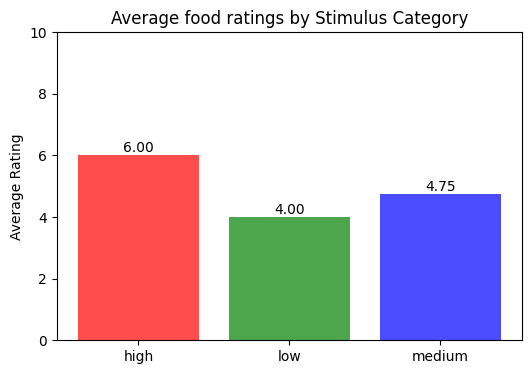

In [50]:
stim_info = [
    {
        'stimulus': stim,
        'rating': rating,
        'category': label_category(stim.split('_')[0], stim.split('_')[2])
    }
    for stim, rating in zip(basic_info['image_order'], basic_info['ratings'])
]
df_stim = pd.DataFrame(stim_info)
avg_per_category = df_stim.groupby('category')['rating'].mean()
plt.figure(figsize=(6,4))
bars = plt.bar(avg_per_category.index, avg_per_category.values, color=['red','green','blue'], alpha=0.7)

# Add text labels on top of bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f"{bar.get_height():.2f}", ha='center')

plt.ylabel('Average Rating')
plt.title('Average food ratings by Stimulus Category')
plt.ylim(0, 10)
plt.show()

OLD BELOW

In [ ]:
free_texts = df['explanation_box.text'].dropna().tolist()

for i, text in enumerate(free_texts, 1):
    print(f"Response {i}: {text}")

print("Feedback:", df['feedback_text.text'].dropna().to_list())
print("Trial stop time:", df['ISI.stopped'].dropna().tolist()[-1])


  stimulus  rating category
0    N_B_C     5.0      low
1    T_Y_C     4.0   medium
2    T_B_C     6.0   medium
3    N_B_S     6.0   medium
4    N_Y_C     7.0      low
5    N_Y_S     8.0   medium
6    T_Y_S     8.0     high
7    T_B_S     9.0     high
category
high      8.5
low       6.0
medium    6.0
Name: rating, dtype: float64


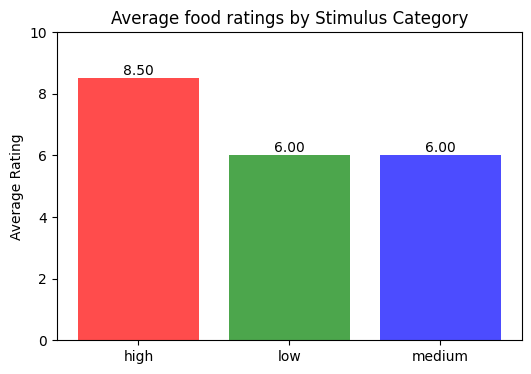

In [63]:
# Assign food amount categories
def label_category(tail, shape):
    if tail == "T" and shape == "S":
        return "high"
    elif tail == "N" and shape == "C":
        return "low"
    else:
        return "medium"

# Find the rows with data
images_row = df[df['images_list'].notna()].iloc[0]
ratings_row = df[df['sliderRatings'].notna()].iloc[0]

# Create list of image and ratings in order
images = [img.split('/')[-1].replace('.png','') for img in images_row['images_list'].split(',')]
ratings = [float(r) for r in ratings_row['sliderRatings'].strip('[]').split(',')]

# Dataframe with relevant info
stim_info = [
    {
        'stimulus': stim,
        'rating': rating,
        'category': label_category(stim.split('_')[0], stim.split('_')[2])
    }
    for stim, rating in zip(images, ratings)
]

df_stim = pd.DataFrame(stim_info)
print(df_stim)

# Compute average rating per category
avg_per_category = df_stim.groupby('category')['rating'].mean()
print(avg_per_category)

# Plot
plt.figure(figsize=(6,4))
bars = plt.bar(avg_per_category.index, avg_per_category.values, color=['red','green','blue'], alpha=0.7)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f"{bar.get_height():.2f}", ha='center')
plt.ylabel('Average Rating')
plt.title('Average food ratings by Stimulus Category')
plt.ylim(0, 10)
plt.show()


In [64]:
columns_to_extract = [
    'shape_discrete_slider.response',
    'color_discrete_slider.response',
    'tail_discrete_slider.response',
    'shape_direction_slider.response',
    'color_direction_slider.response',
    'tail_direction_slider.response',
    'shape_continuous_slider.response',
    'color_continuous_slider.response',
    'tail_continuous_slider.response'
]

data_dict = {}


for col in columns_to_extract:
    nonempty_rows = df[df[col].notna()]
    
    if not nonempty_rows.empty:
        # Store the value from the first non-empty row
        val = nonempty_rows.iloc[0][col]
        data_dict[col] = val
    else:
        # No data: store NaN
        data_dict[col] = np.nan

# Convert to DataFrame with a single row
df_sliders = pd.DataFrame([data_dict])
print(df_sliders)

  shape_discrete_slider.response color_discrete_slider.response  \
0                            Yes                             No   

  tail_discrete_slider.response shape_direction_slider.response  \
0                            No                          Square   

   color_direction_slider.response  tail_direction_slider.response  \
0                              NaN                             NaN   

   shape_continuous_slider.response  color_continuous_slider.response  \
0                               5.0                               NaN   

   tail_continuous_slider.response  
0                              NaN  


Old

In [ ]:
# Pick the 8th row (Python is 0-indexed, so row 7)
images_str = df.loc[7, 'images_list']
ratings_str = df.loc[31, 'sliderRatings']

# Convert to lists
images = [img.strip() for img in images_str.split(',')]

stimulus_types = [img.split('/')[-1].replace('.png','') for img in images]

ratings_str_clean = ratings_str.strip('[]')

ratings = [float(r.strip()) for r in ratings_str_clean.split(',')]

stimulus_types = [img.split('/')[-1].replace('.png','') for img in images]
stimulus_ratings = list(zip(stimulus_types, ratings))

for stim, rating in stimulus_ratings:
    print(f"{stim}: {rating}")



In [ ]:
import matplotlib.pyplot as plt
def label_category(tail, shape):
    if tail == "T" and shape == "S":
        return "high"
    elif tail == "N" and shape == "C":
        return "low"
    else:
        return "medium"

stim_info = []
for stim in stimulus_types:
    parts = stim.split('_')  # ['N', 'Y', 'C']
    tail = parts[0]          # N or T
    shape = parts[2]         # C or S
    category = label_category(tail, shape)
    stim_info.append({'stimulus': stim, 'rating': ratings[stimulus_types.index(stim)], 'category': category})

# Convert to DataFrame for easier grouping
df_stim = pd.DataFrame(stim_info)

# Compute average rating per category
avg_per_category = df_stim.groupby('category')['rating'].mean()

print(avg_per_category)
